In [1]:
!pip uninstall torch torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib -y
!pip install torch==2.5.0+cu124 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
!pip install torch-geometric --no-cache-dir
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib --no-cache-dir --find-links https://data.pyg.org/whl/torch-2.5.0+cu124.html

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
     ━━

In [1]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.6 MB/s eta 0:00:00


##Building the Heterogeneous Graph from PrimeKG
This script processes a cleaned version of the PrimeKG dataset and prepares it for training relational GNN models using PyTorch Geometric. The key goal is to construct a heterogeneous graph in the form of a HeteroData object, which allows different types of nodes and edges to be handled independently.


1. **Text Cleaning:**

All node names are lowercased and normalized to remove inconsistencies (e.g., trailing spaces, case mismatches).

2. **Type Normalization:**

Biomedical entities are mapped into consistent node types like "drug", "disease", "phenotype", etc., to reduce redundancy and noise in the graph schema.

3.** Node Extraction:**

Unique entities (nodes) are collected and grouped by type. These are stored in a dictionary node_sets for each node category.

4. **Relation Mapping:**

For each unique edge relation, the script identifies the source and target node types, storing this in relation_map. This allows the graph to keep track of which types of nodes each relation connects (e.g., "drug ➝ disease").

5. **Node Index Mapping:**

Node names are mapped to integer indices per type using node_maps. These mappings are needed to build numerical edge_index tensors.

6. **Graph Construction with HeteroData:**

The HeteroData object allows explicit specification of:

- Multiple node types, each with its own feature matrix.

- Multiple edge types between different node pairs.

Each node type gets a randomly initialized feature matrix of shape (num_nodes, 128).
Each edge type (relation) is added using the appropriate (source_type, relation, target_type) tuple as key and corresponding edge_index tensor.


# Role of HeteroData

HeteroData is a core PyTorch Geometric data structure used to represent heterogeneous graphs, where nodes and edges can belong to different types. It enables:

- Independent handling of different node types with distinct features.

- Modeling of complex multi-relational structures, like those in biomedical graphs.

- Compatibility with relational layers like RGCNConv, HANConv, or HGTConv.

In [2]:
import torch
import torch.nn.functional as F
import pandas as pd
from torch_geometric.nn import RGCNConv
from torch_geometric.data import HeteroData
from torch_geometric.utils import k_hop_subgraph
from pyvis.network import Network
import unicodedata
import pickle

# Load data
df = pd.read_csv("/content/drive/MyDrive/filtered_primekg.csv", low_memory=False)

# Clean names
def clean_text(text):
    return unicodedata.normalize("NFKD", str(text)).strip().lower()

df["x_name"] = df["x_name"].apply(clean_text)
df["y_name"] = df["y_name"].apply(clean_text)

# Normalize types
node_type_mapping = {
    "gene/protein": "protein",
    "chemical/drug": "drug",
    "drug": "drug",
    "disease": "disease",
    "biological_process": "bioprocess",
    "bioprocess": "bioprocess",
    "pathway": "pathway",
    "effect/phenotype": "phenotype"
}
df["x_type"] = df["x_type"].map(node_type_mapping)
df["y_type"] = df["y_type"].map(node_type_mapping)

#  Extract nodes and relations
node_sets = {t: set() for t in node_type_mapping.values()}
for t in node_sets.keys():
    x_nodes = set(df[df["x_type"] == t]["x_name"].dropna().unique())
    y_nodes = set(df[df["y_type"] == t]["y_name"].dropna().unique())
    node_sets[t] = x_nodes | y_nodes

relation_map = {}
actual_relations = set(df["relation"].unique())
for rel in actual_relations:
    x_type = df[df["relation"] == rel]["x_type"].iloc[0]
    y_type = df[df["relation"] == rel]["y_type"].iloc[0]
    if x_type in node_sets and y_type in node_sets:
        relation_map[rel] = (x_type, y_type)

# Create node maps
node_maps = {k: {name: i for i, name in enumerate(sorted(v))} for k, v in node_sets.items()}

# Create HeteroData
hetero_data = HeteroData()
for node_type, name_to_id in node_maps.items():
    hetero_data[node_type].num_nodes = len(name_to_id)
    hetero_data[node_type].x = torch.randn(len(name_to_id), 128)

for rel, (src_type, dst_type) in relation_map.items():
    rel_df = df[df['relation'] == rel]
    src_ids = rel_df['x_name'].map(node_maps[src_type]).fillna(-1).astype(int)
    dst_ids = rel_df['y_name'].map(node_maps[dst_type]).fillna(-1).astype(int)
    valid_mask = (src_ids != -1) & (dst_ids != -1)
    edge_index = torch.tensor([src_ids[valid_mask].values, dst_ids[valid_mask].values], dtype=torch.long)
    hetero_data[(src_type, rel, dst_type)].edge_index = edge_index

# Save HeteroData using torch.save (safe)
torch.save(hetero_data.to_dict(), "/content/drive/MyDrive/hetero_data_dict_version_final.pt")

# Save node_maps safely with pickle
with open("/content/drive/MyDrive/node_maps_version_final.pkl", "wb") as f:
    pickle.dump(node_maps, f)

print("Saved hetero_data and node_maps successfully.")

<ipython-input-2-f034d7063edb>:64: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  edge_index = torch.tensor([src_ids[valid_mask].values, dst_ids[valid_mask].values], dtype=torch.long)


Saved hetero_data and node_maps successfully.


##Training an R-GCN for Link Prediction with Dot Product Decoder
This script trains a Relational Graph Convolutional Network (R-GCN) on a selected edge type from PrimeKG for a binary link prediction task, using a dot product decoder. It evaluates performance using a train-test split and standard classification metrics.

**Key Components:**

Model Architecture: RGCNLinkPredictor

A two-layer R-GCN model built using RGCNConv.

- Accepts heterogeneous edge types by aggregating all edges into unified edge_index and edge_type tensors.

- Outputs node embeddings after message passing through two convolutional layers.

**Edge Supervision**

- Training is performed on a single edge type from the heterogeneous graph (e.g., "drug ➝ disease").

- The positive samples are real edges of that type.

- Negative edges are generated using negative_sampling to simulate non-existent links.

**Dot Product Decoder**

- Link scores are computed by taking the dot product between source and target node embeddings.

- These scores are used to estimate the probability of a link existing between two nodes.

**Loss Function**

Uses BCEWithLogitsLoss for binary classification, combining sigmoid activation and binary cross-entropy loss in one step.

**Evaluation Metrics**

At each epoch, the model logs:

- AUC (Area Under ROC Curve)

- F1 Score

- Precision, Recall

- Accuracy

- Training and Validation Loss


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
from torch_geometric.utils import negative_sampling
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
)
import json

# --- Device and Graph Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hetero_data = hetero_data.to(device)

edge_types = list(hetero_data.edge_types)
relation_to_id = {rel: i for i, rel in enumerate(edge_types)}

# --- Model Definition ---
class RGCNLinkPredictor(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_dim, hidden_dim, num_relations)
        self.conv2 = RGCNConv(hidden_dim, out_dim, num_relations)

    def forward(self, x, edge_index_dict):
        edge_index_all = []
        edge_type_all = []

        for i, (edge_type, edge_index) in enumerate(edge_index_dict.items()):
            rel_id = relation_to_id[edge_type]
            edge_index_all.append(edge_index)
            edge_type_all.append(torch.full((edge_index.size(1),), rel_id, dtype=torch.long, device=edge_index.device))

        edge_index_cat = torch.cat(edge_index_all, dim=1)
        edge_type_cat = torch.cat(edge_type_all, dim=0)

        x_all = torch.cat([x[ntype] for ntype in hetero_data.node_types], dim=0)
        out = self.conv1(x_all, edge_index_cat, edge_type_cat)
        out = F.relu(out)
        out = self.conv2(out, edge_index_cat, edge_type_cat)
        return out

# --- Training Setup ---
in_dim = 128
hidden_dim = 256
out_dim = 128
num_relations = len(edge_types)

model = RGCNLinkPredictor(in_dim, hidden_dim, out_dim, num_relations).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.BCEWithLogitsLoss()

metrics_log = {
    "train_loss": [],
    "val_loss": [],
    "auc": [],
    "f1_score": [],
    "precision": [],
    "recall": [],
    "accuracy": []
}

print("\n[INFO] Starting R-GCN training with Dot Product Decoder and Clean Validation Setup...")

# --- Select One Relation to Supervise ---
edge_type = edge_types[0]
src, dst = hetero_data[edge_type].edge_index
pos_edges = torch.stack([src, dst], dim=1).cpu().numpy()

# --- Train/Validation Positive Split ---
train_pos, val_pos = train_test_split(pos_edges, test_size=0.2, random_state=42)
train_pos = torch.tensor(train_pos, dtype=torch.long).t().to(device)
val_pos = torch.tensor(val_pos, dtype=torch.long).t().to(device)

# --- Precompute Validation Negatives (FIX) ---
z_dummy = torch.cat([hetero_data.x_dict[nt] for nt in hetero_data.node_types], dim=0)
fixed_val_neg = negative_sampling(
    edge_index=val_pos,
    num_nodes=z_dummy.size(0),
    num_neg_samples=val_pos.size(1)
).to(device)

# --- Training Loop ---
for epoch in range(1, 401):
    model.train()
    optimizer.zero_grad()

    z = model(hetero_data.x_dict, hetero_data.edge_index_dict)

    # --- Sample Training Negatives ---
    neg_train = negative_sampling(
        edge_index=train_pos,
        num_nodes=z.size(0),
        num_neg_samples=train_pos.size(1)
    )

    train_edges = torch.cat([train_pos, neg_train], dim=1)
    train_labels = torch.cat([
        torch.ones(train_pos.size(1), device=device),
        torch.zeros(neg_train.size(1), device=device)
    ])

    train_src = z[train_edges[0]]
    train_dst = z[train_edges[1]]
    train_pred = (train_src * train_dst).sum(dim=-1)

    loss = criterion(train_pred, train_labels)
    loss.backward()
    optimizer.step()

    # --- Validation (Fixed Negatives) ---
    model.eval()
    with torch.no_grad():
        val_edges = torch.cat([val_pos, fixed_val_neg], dim=1)
        val_labels = torch.cat([
            torch.ones(val_pos.size(1), device=device),
            torch.zeros(fixed_val_neg.size(1), device=device)
        ])

        val_src = z[val_edges[0]]
        val_dst = z[val_edges[1]]
        val_pred = (val_src * val_dst).sum(dim=-1)

        val_loss = criterion(val_pred, val_labels).item()
        val_probs = torch.sigmoid(val_pred).cpu().numpy()
        val_preds = (val_probs > 0.5).astype(int)
        y_true = val_labels.cpu().numpy()

        metrics_log["train_loss"].append(loss.item())
        metrics_log["val_loss"].append(val_loss)
        metrics_log["auc"].append(roc_auc_score(y_true, val_probs))
        metrics_log["f1_score"].append(f1_score(y_true, val_preds))
        metrics_log["precision"].append(precision_score(y_true, val_preds))
        metrics_log["recall"].append(recall_score(y_true, val_preds))
        metrics_log["accuracy"].append(accuracy_score(y_true, val_preds))

        if epoch % 10 == 0:
            print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss:.4f} | AUC: {metrics_log['auc'][-1]:.4f}")

# --- Save Model and Metrics ---
torch.save(model.state_dict(), "/content/drive/MyDrive/rgcn_dotprod_v4.pt")
with open("/content/drive/MyDrive/rgcn_dotprod_metrics.json", "w") as f:
    json.dump(metrics_log, f)

print("\n Training complete and metrics saved.")



[INFO] Starting R-GCN training with Dot Product Decoder and Clean Validation Setup...
Epoch 010 | Train Loss: 2.0153 | Val Loss: 2.0113 | AUC: 0.7333
Epoch 020 | Train Loss: 0.7475 | Val Loss: 0.7523 | AUC: 0.9711
Epoch 030 | Train Loss: 0.4974 | Val Loss: 0.4938 | AUC: 0.9876
Epoch 040 | Train Loss: 0.4254 | Val Loss: 0.4312 | AUC: 0.9878
Epoch 050 | Train Loss: 0.3997 | Val Loss: 0.4050 | AUC: 0.9921
Epoch 060 | Train Loss: 0.3885 | Val Loss: 0.3952 | AUC: 0.9944
Epoch 070 | Train Loss: 0.3809 | Val Loss: 0.3912 | AUC: 0.9946
Epoch 080 | Train Loss: 0.3847 | Val Loss: 0.3886 | AUC: 0.9947
Epoch 090 | Train Loss: 0.3799 | Val Loss: 0.3879 | AUC: 0.9945
Epoch 100 | Train Loss: 0.3760 | Val Loss: 0.3875 | AUC: 0.9938
Epoch 110 | Train Loss: 0.3739 | Val Loss: 0.3855 | AUC: 0.9936
Epoch 120 | Train Loss: 0.3744 | Val Loss: 0.3841 | AUC: 0.9935
Epoch 130 | Train Loss: 0.3684 | Val Loss: 0.3823 | AUC: 0.9936
Epoch 140 | Train Loss: 0.3700 | Val Loss: 0.3819 | AUC: 0.9937
Epoch 150 | Train

## RGCN with DISTMULT VERSION (Enhanced Decoder)



### DistMult Decoder

**Encoder: RGCNLinkEncoder**

- A two-layer R-GCN encoder that aggregates features over the entire heterogeneous graph.

- Combines all relation-specific edges using RGCNConv, allowing the model to learn node embeddings that are conditioned on typed edges.


**Decoder: DistMultDecoder**

The DistMult decoder computes the plausibility of a triple \((i, r, j)\) using a relation-specific scoring function:

$$
\text{score} = h_i^T \cdot R_r \cdot h_j
$$

Where:

- $h_i$ and $h_j$ are the embeddings of the source and target nodes.
- $R_r$ is a **relation-specific diagonal matrix** for relation $r$.
- $h_i^T \cdot R_r \cdot h_j$ computes a weighted interaction between the embeddings based on the relation type.
- This allows the model to **differentiate scores for different types of edges**, which is especially useful in multi-relational graphs like PrimeKG.


Each relation is modeled via a trainable vector, and the score reflects how compatible the embeddings are under that relation. This allows the model to learn **relation-specific transformations** — a key advantage in multi-relational graphs like PrimeKG.

**Training Details**

- Supervised on a single edge type from the graph (e.g., "protein ➝ disease").

- Positive edges are real links from the dataset; negative edges are generated using negative_sampling.

The link prediction task is framed as binary classification using BCEWithLogitsLoss.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
from torch_geometric.utils import negative_sampling
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hetero_data = hetero_data.to(device)

edge_types = list(hetero_data.edge_types)
relation_to_id = {rel: i for i, rel in enumerate(edge_types)}

class RGCNLinkEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_dim, hidden_dim, num_relations)
        self.conv2 = RGCNConv(hidden_dim, out_dim, num_relations)

    def forward(self, x, edge_index_dict):
        edge_index_all, edge_type_all = [], []
        for edge_type, edge_index in edge_index_dict.items():
            rel_id = relation_to_id[edge_type]
            edge_index_all.append(edge_index)
            edge_type_all.append(torch.full((edge_index.size(1),), rel_id, dtype=torch.long, device=edge_index.device))
        edge_index_cat = torch.cat(edge_index_all, dim=1)
        edge_type_cat = torch.cat(edge_type_all, dim=0)
        x_all = torch.cat([x[ntype] for ntype in hetero_data.node_types], dim=0)
        out = F.relu(self.conv1(x_all, edge_index_cat, edge_type_cat))
        out = self.conv2(out, edge_index_cat, edge_type_cat)
        return out

class DistMultDecoder(nn.Module):
    def __init__(self, embedding_dim, num_relations):
        super().__init__()
        self.relation_embeddings = nn.Embedding(num_relations, embedding_dim)

    def forward(self, z, edge_label_index, edge_type_ids):
        src = z[edge_label_index[0]]
        dst = z[edge_label_index[1]]
        rel = self.relation_embeddings(edge_type_ids)
        return (src * rel * dst).sum(dim=-1)

# Model setup
in_dim, hidden_dim, out_dim = 128, 256, 128
num_relations = len(edge_types)
encoder = RGCNLinkEncoder(in_dim, hidden_dim, out_dim, num_relations).to(device)
decoder = DistMultDecoder(out_dim, num_relations).to(device)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.005)
criterion = nn.BCEWithLogitsLoss()

# Metric tracking
train_loss_list, val_loss_list = [], []
f1_list, precision_list, recall_list, accuracy_list, auc_list = [], [], [], [], []

print("\n[INFO] Starting R-GCN + DistMult training with fixed val negatives...")

# Use a single relation type for supervision
edge_type = edge_types[0]
rel_id = relation_to_id[edge_type]
src, dst = hetero_data[edge_type].edge_index
pos_edge_index = torch.stack([src, dst], dim=0)

# Train/val split on positive edges
pos_edge_np = pos_edge_index.cpu().numpy().T
train_pos_np, val_pos_np = train_test_split(pos_edge_np, test_size=0.2, random_state=42)
train_pos_edge = torch.tensor(train_pos_np.T, dtype=torch.long, device=device)
val_pos_edge = torch.tensor(val_pos_np.T, dtype=torch.long, device=device)

# Fixed val negatives
num_nodes = torch.cat([x for x in hetero_data.x_dict.values()], dim=0).shape[0]
fixed_val_neg = negative_sampling(val_pos_edge, num_nodes=num_nodes, num_neg_samples=val_pos_edge.shape[1])

# Training loop
for epoch in range(1, 401):
    encoder.train()
    decoder.train()
    optimizer.zero_grad()

    z = encoder(hetero_data.x_dict, hetero_data.edge_index_dict)

    # Sample new train negatives
    neg_train_edge = negative_sampling(train_pos_edge, num_nodes=z.size(0), num_neg_samples=train_pos_edge.shape[1])
    train_edge_index = torch.cat([train_pos_edge, neg_train_edge], dim=1)
    train_labels = torch.cat([
        torch.ones(train_pos_edge.shape[1], device=device),
        torch.zeros(neg_train_edge.shape[1], device=device)
    ])
    edge_type_ids_train = torch.full((train_edge_index.shape[1],), rel_id, dtype=torch.long, device=device)
    train_pred = decoder(z, train_edge_index, edge_type_ids_train)
    train_loss = criterion(train_pred, train_labels)
    train_loss.backward()
    optimizer.step()

    # Evaluation on fixed val edges
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        val_edge_index = torch.cat([val_pos_edge, fixed_val_neg], dim=1)
        val_labels = torch.cat([
            torch.ones(val_pos_edge.shape[1], device=device),
            torch.zeros(fixed_val_neg.shape[1], device=device)
        ])
        edge_type_ids_val = torch.full((val_edge_index.shape[1],), rel_id, dtype=torch.long, device=device)
        val_pred = decoder(z, val_edge_index, edge_type_ids_val)
        val_loss = criterion(val_pred, val_labels)

        val_probs = torch.sigmoid(val_pred).cpu().numpy()
        val_preds = (val_probs > 0.5).astype(int)
        y_true = val_labels.cpu().numpy()

        auc = roc_auc_score(y_true, val_probs)
        acc = accuracy_score(y_true, val_preds)
        precision = precision_score(y_true, val_preds)
        recall = recall_score(y_true, val_preds)
        f1 = f1_score(y_true, val_preds)

        train_loss_list.append(train_loss.item())
        val_loss_list.append(val_loss.item())
        auc_list.append(auc)
        accuracy_list.append(acc)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        if epoch % 10 == 0:
            print(f"Epoch {epoch:03d} | Train Loss: {train_loss.item():.4f} | Val Loss: {val_loss.item():.4f} | AUC: {auc:.4f}")

# Save model and metrics
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'relation_to_id': relation_to_id
}, "/content/drive/MyDrive/rgcn_distmult_v4_metrics.pt")

with open("/content/drive/MyDrive/rgcn_distmult_metrics.json", "w") as f:
    json.dump({
        "train_loss": train_loss_list,
        "val_loss": val_loss_list,
        "accuracy": accuracy_list,
        "precision": precision_list,
        "recall": recall_list,
        "f1_score": f1_list,
        "roc_auc": auc_list
    }, f)

print("\nTraining complete. Model and metrics saved.")



[INFO] Starting R-GCN + DistMult training with fixed val negatives...
Epoch 010 | Train Loss: 1.4968 | Val Loss: 1.6788 | AUC: 0.9687
Epoch 020 | Train Loss: 0.5413 | Val Loss: 0.6622 | AUC: 0.9845
Epoch 030 | Train Loss: 0.2704 | Val Loss: 0.5133 | AUC: 0.9920
Epoch 040 | Train Loss: 0.1009 | Val Loss: 0.1799 | AUC: 0.9957
Epoch 050 | Train Loss: 0.0490 | Val Loss: 0.2203 | AUC: 0.9948
Epoch 060 | Train Loss: 0.0389 | Val Loss: 0.1854 | AUC: 0.9947
Epoch 070 | Train Loss: 0.0234 | Val Loss: 0.2006 | AUC: 0.9941
Epoch 080 | Train Loss: 0.0223 | Val Loss: 0.2135 | AUC: 0.9939
Epoch 090 | Train Loss: 0.0203 | Val Loss: 0.2121 | AUC: 0.9943
Epoch 100 | Train Loss: 0.0140 | Val Loss: 0.2191 | AUC: 0.9944
Epoch 110 | Train Loss: 0.0121 | Val Loss: 0.2195 | AUC: 0.9946
Epoch 120 | Train Loss: 0.0132 | Val Loss: 0.2258 | AUC: 0.9947
Epoch 130 | Train Loss: 0.0188 | Val Loss: 0.2189 | AUC: 0.9950
Epoch 140 | Train Loss: 0.0135 | Val Loss: 0.2283 | AUC: 0.9950
Epoch 150 | Train Loss: 0.0101 | 

### Multi-Relation Training with R-GCN + DistMult

This script trains a **Relational Graph Convolutional Network (R-GCN)** using a **DistMult decoder** over **all edge types simultaneously**. It extends the single-relation version by jointly supervising on every relation present in the heterogeneous graph.

Unlike earlier experiments where models were trained on a single relation at a time, this setup allows the model to learn a **richer, global representation** of the graph by considering multiple relation types during training.

---

#### Core Setup:

- **Encoder**: A two-layer R-GCN model that encodes nodes using all edges from the graph.
- **Decoder**: A DistMult decoder that uses a **relation-specific embedding** to score the plausibility of a link.
- **Negative Sampling**: Used for each relation type to generate negative examples for training.
- **Loss Function**: Binary cross-entropy over both positive and negative edges for each relation.
- **Multi-Relation Supervision**: Each relation is trained and evaluated **independently**, and metrics are logged separately.

---

#### Why This Matters:

This configuration helps the model capture **cross-relational patterns**, which are often critical in biomedical knowledge graphs like PrimeKG. For example, learning a better embedding for a disease node in a drug-disease edge can improve its performance in phenotype-disease predictions as well.

Each relation type contributes to:
- Improved generalization across the graph.
- More robust and diverse node embeddings.
- Richer understanding of context via multi-hop, multi-relational reasoning.

---

#### Output:

- The trained encoder and decoder weights are saved to a `.pt` file.
- Performance metrics (e.g., F1 score, AUC, precision, recall) are logged **per edge type** in a `.json` file for later visualization and comparison.



In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
from torch_geometric.utils import negative_sampling
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
import json

# Assume hetero_data is already defined and loaded
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hetero_data = hetero_data.to(device)

edge_types = list(hetero_data.edge_types)
relation_to_id = {rel: i for i, rel in enumerate(edge_types)}

class RGCNLinkEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_dim, hidden_dim, num_relations)
        self.conv2 = RGCNConv(hidden_dim, out_dim, num_relations)

    def forward(self, x, edge_index_dict):
        edge_index_all, edge_type_all = [], []
        for edge_type, edge_index in edge_index_dict.items():
            rel_id = relation_to_id[edge_type]
            edge_index_all.append(edge_index)
            edge_type_all.append(torch.full((edge_index.size(1),), rel_id, dtype=torch.long, device=edge_index.device))
        edge_index_cat = torch.cat(edge_index_all, dim=1)
        edge_type_cat = torch.cat(edge_type_all, dim=0)
        x_all = torch.cat([x[nt] for nt in hetero_data.node_types], dim=0)
        out = F.relu(self.conv1(x_all, edge_index_cat, edge_type_cat))
        out = self.conv2(out, edge_index_cat, edge_type_cat)
        return out

class DistMultDecoder(nn.Module):
    def __init__(self, embedding_dim, num_relations):
        super().__init__()
        self.relation_embeddings = nn.Embedding(num_relations, embedding_dim)

    def forward(self, z, edge_label_index, edge_type_ids):
        src = z[edge_label_index[0]]
        dst = z[edge_label_index[1]]
        rel = self.relation_embeddings(edge_type_ids)
        return (src * rel * dst).sum(dim=-1)

# Hyperparameters
in_dim, hidden_dim, out_dim = 128, 256, 128
num_relations = len(edge_types)

# Model and optimizer
encoder = RGCNLinkEncoder(in_dim, hidden_dim, out_dim, num_relations).to(device)
decoder = DistMultDecoder(out_dim, num_relations).to(device)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.005)
criterion = nn.BCEWithLogitsLoss()

metrics = {
    et: {
        "train_loss": [], "val_loss": [], "accuracy": [],
        "precision": [], "recall": [], "f1_score": [], "roc_auc": []
    }
    for et in edge_types
}

print("\n[INFO] Starting clean multi-relation DistMult training...")

for epoch in range(1, 401):
    encoder.train()
    decoder.train()
    optimizer.zero_grad()
    z = encoder(hetero_data.x_dict, hetero_data.edge_index_dict)
    total_loss = 0

    for edge_type in edge_types:
        rel_id = relation_to_id[edge_type]
        src, dst = hetero_data[edge_type].edge_index
        if src.size(0) == 0:
            continue

        # Step 1: Split positives first
        pos_edges_np = torch.stack([src, dst], dim=1).cpu().numpy()
        train_pos_np, val_pos_np = train_test_split(pos_edges_np, test_size=0.2, random_state=42)
        train_pos = torch.tensor(train_pos_np.T, dtype=torch.long, device=device)
        val_pos = torch.tensor(val_pos_np.T, dtype=torch.long, device=device)

        # Step 2: Sample negatives after split
        neg_train = negative_sampling(train_pos, num_nodes=z.size(0), num_neg_samples=train_pos.shape[1])
        neg_val = negative_sampling(val_pos, num_nodes=z.size(0), num_neg_samples=val_pos.shape[1])

        # Step 3: Prepare train and val edge-label sets
        train_edges = torch.cat([train_pos, neg_train], dim=1)
        train_labels = torch.cat([
            torch.ones(train_pos.shape[1], device=device),
            torch.zeros(neg_train.shape[1], device=device)
        ])
        val_edges = torch.cat([val_pos, neg_val], dim=1)
        val_labels = torch.cat([
            torch.ones(val_pos.shape[1], device=device),
            torch.zeros(neg_val.shape[1], device=device)
        ])
        edge_type_train = torch.full((train_edges.shape[1],), rel_id, dtype=torch.long, device=device)
        edge_type_val = torch.full((val_edges.shape[1],), rel_id, dtype=torch.long, device=device)

        # Step 4: Forward and loss
        train_pred = decoder(z, train_edges, edge_type_train)
        val_pred = decoder(z, val_edges, edge_type_val)
        train_loss = criterion(train_pred, train_labels)
        val_loss = criterion(val_pred, val_labels)
        total_loss += train_loss

        # Step 5: Metrics
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            val_probs = torch.sigmoid(val_pred).cpu().numpy()
            val_preds = (val_probs > 0.5).astype(int)
            y_true = val_labels.cpu().numpy()

            try:
                auc = roc_auc_score(y_true, val_probs)
            except:
                auc = 0.0

            metrics[edge_type]["train_loss"].append(train_loss.item())
            metrics[edge_type]["val_loss"].append(val_loss.item())
            metrics[edge_type]["roc_auc"].append(auc)
            metrics[edge_type]["accuracy"].append(accuracy_score(y_true, val_preds))
            metrics[edge_type]["precision"].append(precision_score(y_true, val_preds, zero_division=0))
            metrics[edge_type]["recall"].append(recall_score(y_true, val_preds, zero_division=0))
            metrics[edge_type]["f1_score"].append(f1_score(y_true, val_preds, zero_division=0))

    if total_loss != 0:
        total_loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Avg Train Loss: {total_loss.item():.4f}")

# Save
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'relation_to_id': relation_to_id
}, "/content/drive/MyDrive/rgcn_distmult_multirel_metrics.pt")

with open("/content/drive/MyDrive/rgcn_distmult_multirel_metrics.json", "w") as f:
    json.dump({str(k): v for k, v in metrics.items()}, f)

print("\n Training complete with clean train/val split. Model and metrics saved.")



[INFO] Starting clean multi-relation DistMult training...
Epoch 010 | Avg Train Loss: 3.8388
Epoch 020 | Avg Train Loss: 2.1246
Epoch 030 | Avg Train Loss: 1.2894
Epoch 040 | Avg Train Loss: 0.9738
Epoch 050 | Avg Train Loss: 0.8441
Epoch 060 | Avg Train Loss: 0.7665
Epoch 070 | Avg Train Loss: 0.7339
Epoch 080 | Avg Train Loss: 0.6912
Epoch 090 | Avg Train Loss: 0.6624
Epoch 100 | Avg Train Loss: 0.6386
Epoch 110 | Avg Train Loss: 0.6227
Epoch 120 | Avg Train Loss: 0.6093
Epoch 130 | Avg Train Loss: 0.5926
Epoch 140 | Avg Train Loss: 0.5760
Epoch 150 | Avg Train Loss: 0.5568
Epoch 160 | Avg Train Loss: 0.5497
Epoch 170 | Avg Train Loss: 0.5392
Epoch 180 | Avg Train Loss: 0.5307
Epoch 190 | Avg Train Loss: 0.5231
Epoch 200 | Avg Train Loss: 0.5104
Epoch 210 | Avg Train Loss: 0.4962
Epoch 220 | Avg Train Loss: 0.4879
Epoch 230 | Avg Train Loss: 0.4843
Epoch 240 | Avg Train Loss: 0.4851
Epoch 250 | Avg Train Loss: 0.4741
Epoch 260 | Avg Train Loss: 0.4653
Epoch 270 | Avg Train Loss: 0.4

## Adding Global Pooling

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv, global_mean_pool
from torch_geometric.utils import negative_sampling
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
import json

# Device & data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hetero_data = hetero_data.to(device)

edge_types = list(hetero_data.edge_types)
relation_to_id = {rel: i for i, rel in enumerate(edge_types)}

# === R-GCN Encoder with Global Pooling ===
class RGCNLinkEncoderWithGlobal(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_dim, hidden_dim, num_relations)
        self.conv2 = RGCNConv(hidden_dim, out_dim, num_relations)
        self.global_pool = global_mean_pool

    def forward(self, x, edge_index_dict, batch=None):
        edge_index_all, edge_type_all = [], []
        for edge_type, edge_index in edge_index_dict.items():
            rel_id = relation_to_id[edge_type]
            edge_index_all.append(edge_index)
            edge_type_all.append(torch.full((edge_index.size(1),), rel_id, dtype=torch.long, device=edge_index.device))
        edge_index_cat = torch.cat(edge_index_all, dim=1)
        edge_type_cat = torch.cat(edge_type_all, dim=0)

        x_all = torch.cat([x[ntype] for ntype in hetero_data.node_types], dim=0)
        out = self.conv1(x_all, edge_index_cat, edge_type_cat)
        out = F.relu(out)
        out = self.conv2(out, edge_index_cat, edge_type_cat)

        if batch is None:
            batch = torch.zeros(out.size(0), dtype=torch.long, device=out.device)

        global_feat = self.global_pool(out, batch)
        return out, global_feat

# === DistMult Decoder ===
class DistMultDecoder(nn.Module):
    def __init__(self, embedding_dim, num_relations):
        super().__init__()
        self.relation_embeddings = nn.Embedding(num_relations, embedding_dim)

    def forward(self, z, edge_label_index, edge_type_ids):
        src = z[edge_label_index[0]]
        dst = z[edge_label_index[1]]
        rel = self.relation_embeddings(edge_type_ids)
        return (src * rel * dst).sum(dim=-1)

# === Model Setup ===
in_dim, hidden_dim, out_dim = 128, 256, 128
num_relations = len(edge_types)

encoder = RGCNLinkEncoderWithGlobal(in_dim, hidden_dim, out_dim, num_relations).to(device)
decoder = DistMultDecoder(out_dim, num_relations).to(device)
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=0.005)

# If needed, use weighted loss for class imbalance
# pos_weight = torch.tensor([2.0]).to(device)
criterion = nn.BCEWithLogitsLoss()  # or: nn.BCEWithLogitsLoss(pos_weight=pos_weight)

metrics_dict = {
    "train_loss": [], "val_loss": [],
    "accuracy": [], "precision": [],
    "recall": [], "f1_score": [], "roc_auc": []
}

print("\n[INFO] Starting Final Enhanced R-GCN with Global Pooling and DistMult Decoder...")

# === Use one relation for binary link prediction ===
edge_type = edge_types[0]
rel_id = relation_to_id[edge_type]
src, dst = hetero_data[edge_type].edge_index
pos_edge_index = torch.stack([src, dst], dim=0)

neg_edge_index = negative_sampling(pos_edge_index, num_nodes=hetero_data.x_dict['protein'].shape[0], num_neg_samples=pos_edge_index.shape[1])
edge_label_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
edge_label = torch.cat([
    torch.ones(pos_edge_index.size(1), device=device),
    torch.zeros(neg_edge_index.size(1), device=device)
])

edge_idx = np.arange(edge_label_index.shape[1])
train_idx, val_idx = train_test_split(edge_idx, test_size=0.2, random_state=42)

# === Training Loop ===
for epoch in range(1, 401):
    encoder.train()
    decoder.train()
    optimizer.zero_grad()

    z, _ = encoder(hetero_data.x_dict, hetero_data.edge_index_dict)
    edge_type_ids = torch.full((edge_label_index.shape[1],), rel_id, dtype=torch.long, device=device)
    pred = decoder(z, edge_label_index, edge_type_ids)

    train_pred = pred[train_idx]
    train_label = edge_label[train_idx]
    val_pred = pred[val_idx]
    val_label = edge_label[val_idx]

    train_loss = criterion(train_pred, train_label)
    val_loss = criterion(val_pred, val_label)
    train_loss.backward()
    optimizer.step()

    with torch.no_grad():
        val_probs = torch.sigmoid(val_pred).cpu().numpy()
        val_preds = (val_probs > 0.5).astype(int)
        val_labels = val_label.cpu().numpy()

        auc = roc_auc_score(val_labels, val_probs)
        acc = accuracy_score(val_labels, val_preds)
        precision = precision_score(val_labels, val_preds, zero_division=0)
        recall = recall_score(val_labels, val_preds, zero_division=0)
        f1 = f1_score(val_labels, val_preds, zero_division=0)

        metrics_dict["train_loss"].append(train_loss.item())
        metrics_dict["val_loss"].append(val_loss.item())
        metrics_dict["roc_auc"].append(auc)
        metrics_dict["accuracy"].append(acc)
        metrics_dict["precision"].append(precision)
        metrics_dict["recall"].append(recall)
        metrics_dict["f1_score"].append(f1)

        if epoch % 10 == 0:
            pos_count = np.sum(val_preds)
            print(f"Epoch {epoch:03d} | Train Loss: {train_loss.item():.4f} | Val Loss: {val_loss.item():.4f} | AUC: {auc:.4f} | Positives: {pos_count}/{len(val_preds)}")

# === Save Results ===
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'relation_to_id': relation_to_id
}, "/content/drive/MyDrive/rgcn_global_pool_distmult_v2.pt")

with open("/content/drive/MyDrive/rgcn_global_pool_distmult_metrics.json", "w") as f:
    json.dump(metrics_dict, f)

print("Saved model and evaluation metrics.")



[INFO] Starting Final Enhanced R-GCN with Global Pooling and DistMult Decoder...
Epoch 010 | Train Loss: 4.5267 | Val Loss: 4.5668 | AUC: 0.6883 | Positives: 1529/57922
Epoch 020 | Train Loss: 0.9594 | Val Loss: 0.9958 | AUC: 0.8097 | Positives: 35497/57922
Epoch 030 | Train Loss: 0.5864 | Val Loss: 0.6164 | AUC: 0.7968 | Positives: 25804/57922
Epoch 040 | Train Loss: 0.5002 | Val Loss: 0.5328 | AUC: 0.8165 | Positives: 28204/57922
Epoch 050 | Train Loss: 0.4782 | Val Loss: 0.5146 | AUC: 0.8380 | Positives: 24926/57922
Epoch 060 | Train Loss: 0.4560 | Val Loss: 0.5002 | AUC: 0.8451 | Positives: 31493/57922
Epoch 070 | Train Loss: 0.4345 | Val Loss: 0.4849 | AUC: 0.8529 | Positives: 26527/57922
Epoch 080 | Train Loss: 0.4163 | Val Loss: 0.4750 | AUC: 0.8581 | Positives: 29637/57922
Epoch 090 | Train Loss: 0.4002 | Val Loss: 0.4670 | AUC: 0.8632 | Positives: 28032/57922
Epoch 100 | Train Loss: 0.3846 | Val Loss: 0.4601 | AUC: 0.8679 | Positives: 29174/57922
Epoch 110 | Train Loss: 0.369

##Performance Evaluation of all the models


### Evaluating Relation-Specific Performance with a Radar Plot for multi-relation DistMult model

This visualization compares the **F1 scores** across selected biomedical relations from the **multi-relation DistMult model**.

Each axis represents a specific edge type (relation) in the graph, such as:
- **Disease ➝ Phenotype**
- **Drug ➝ Effect**
- **Drug ➝ Contraindication**

The plot shows the model’s **final F1 score** for each relation after training. This helps identify which relationships the model captures well and which might require further tuning, additional data, or more expressive encoders.


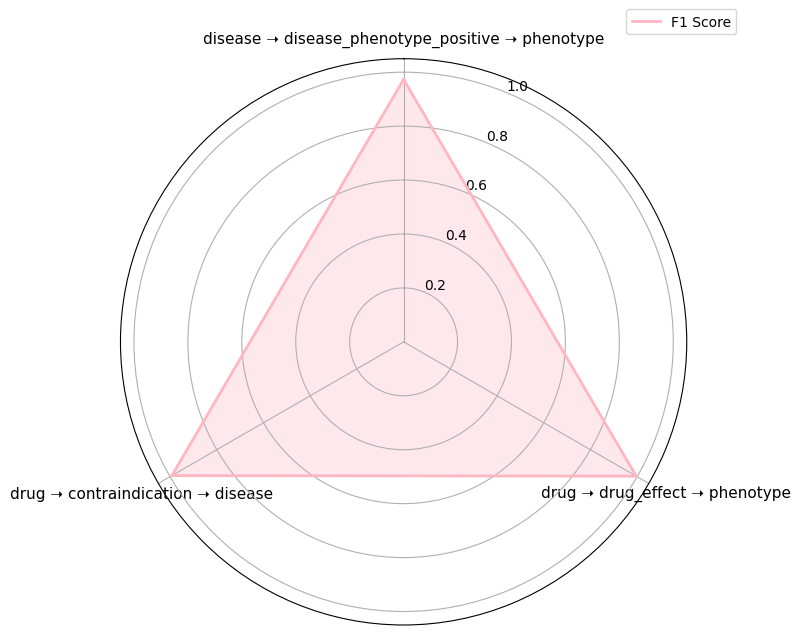

In [7]:
import matplotlib.pyplot as plt

# Load metrics
with open("/content/drive/MyDrive/rgcn_distmult_multirel_metrics.json", "r") as f:
    metrics = json.load(f)

# Relations to compare
target_relations = [
    "('disease', 'disease_phenotype_positive', 'phenotype')",
    "('drug', 'drug_effect', 'phenotype')",
    "('drug', 'contraindication', 'disease')"
]

# Extract F1 scores and readable labels
labels = []
scores = []

for rel in target_relations:
    f1_list = metrics.get(rel, {}).get("f1_score", [])
    if f1_list:
        score = f1_list[-1]
        label = rel.replace("('", "").replace("')", "").replace("', '", " ➝ ")
        scores.append(score)
        labels.append(label)
    else:
        print(f" Skipping missing or empty F1 score for: {rel}")

# Validation check
if len(scores) < 2:
    raise ValueError("Not enough valid F1 scores to plot spider chart.")

# Angles and wrap-around
angles = np.linspace(0, 2 * np.pi, len(scores), endpoint=False).tolist()
scores += scores[:1]
angles += angles[:1]

# Spider plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Plot and fill
ax.plot(angles, scores, linewidth=2, linestyle='solid', color='#FFB6C1', label='F1 Score')
ax.fill(angles, scores, color='#FFB6C1', alpha=0.3)

# Fix grid labels (exclude wraparound point)
ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=11)

# Final touches
ax.set_ylim(0, 1.05)
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.tight_layout()
plt.show()


## Comparing Model Performance on a Single Relation: Drug ➝ Effect ➝ Phenotype

This radar plot compares the **F1 scores** of three different models—**Dot Product**, **DistMult (Single Relation)**, and **DistMult (Multi-Relation)**—on a specific biomedical relation:

$$
(\text{drug}, \ \text{drug_effect}, \ \text{phenotype})
$$

Each spoke on the radar plot corresponds to a model. The F1 score plotted on that axis represents how well the model predicts drug-effect relationships.

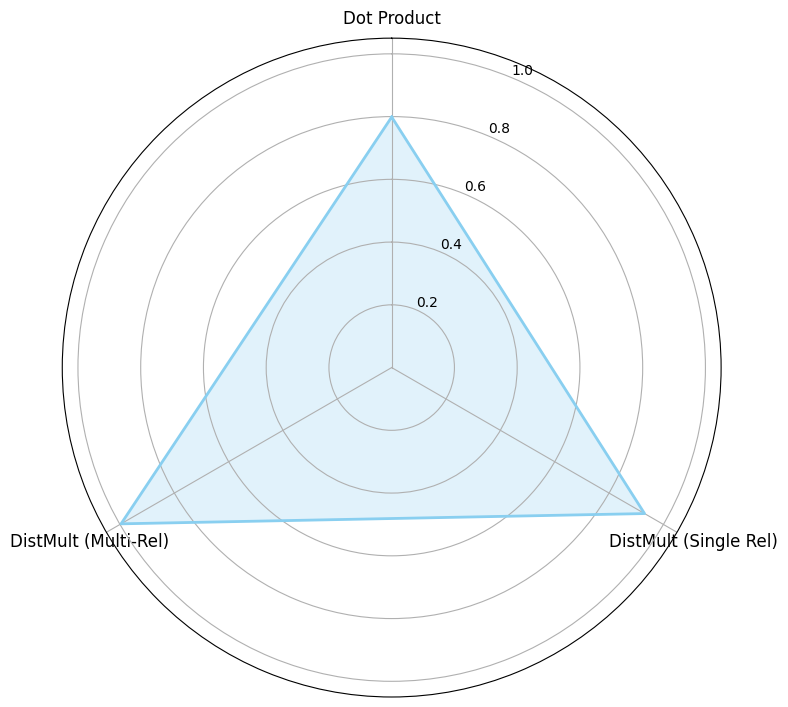

In [8]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Reload the metrics
paths = {
    "Dot Product": "/content/drive/MyDrive/rgcn_dotprod_metrics.json",
    "DistMult (Single Rel)": "/content/drive/MyDrive/rgcn_distmult_metrics.json",
    "DistMult (Multi-Rel)": "/content/drive/MyDrive/rgcn_distmult_multirel_metrics.json"
}

# Relation to focus on
target_relation = "('drug', 'drug_effect', 'phenotype')"

# Extract F1 scores
f1_scores = {}
for model_name, path in paths.items():
    with open(path, "r") as f:
        data = json.load(f)

        if isinstance(data.get("f1_score"), list):
            f1_scores[model_name] = data["f1_score"][-1]
        elif target_relation in data and "f1_score" in data[target_relation]:
            f1_scores[model_name] = data[target_relation]["f1_score"][-1]

if len(f1_scores) < 2:
    raise ValueError("Need at least two models with valid F1 scores to plot.")

# Extract labels and scores
labels = list(f1_scores.keys())
scores = list(f1_scores.values())

# Generate angles
angles = np.linspace(0, 2 * np.pi, len(scores), endpoint=False).tolist()

# Close the circle for plotting
scores += scores[:1]
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.plot(angles, scores, linewidth=2, linestyle='solid', color='#89CFF0')
ax.fill(angles, scores, color='#89CFF0', alpha=0.25)

# Use original labels (not repeated) for theta grid
ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=12)
ax.set_ylim(0, 1.05)

ax.grid(True)

plt.tight_layout()
plt.show()


##Comparing Model Performance on a Single Relation: Disease ➝ disease_phenotype_positive  ➝ Phenotype
This radar plot compares the F1 scores of three different models—Dot Product, DistMult (Single Relation), and DistMult (Multi-Relation)—on a specific biomedical relation:

(disease, disease_phenotype_positive, phenotype)



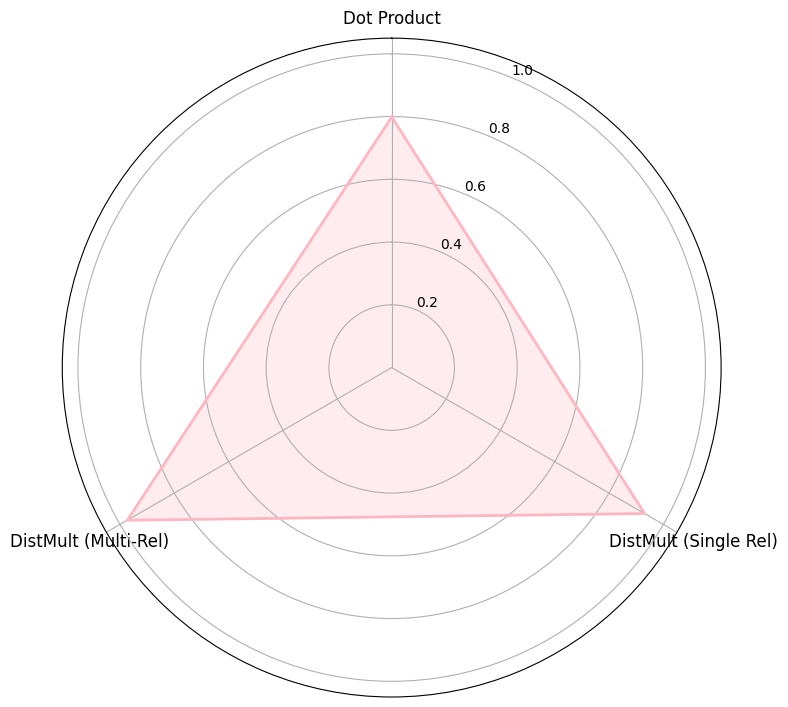

In [9]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Reload the metrics
paths = {
    "Dot Product": "/content/drive/MyDrive/rgcn_dotprod_metrics.json",
    "DistMult (Single Rel)": "/content/drive/MyDrive/rgcn_distmult_metrics.json",
    "DistMult (Multi-Rel)": "/content/drive/MyDrive/rgcn_distmult_multirel_metrics.json"
}

# Relation to focus on
target_relation = "('disease', 'disease_phenotype_positive', 'phenotype')"

# Extract F1 scores
f1_scores = {}
for model_name, path in paths.items():
    with open(path, "r") as f:
        data = json.load(f)

        if isinstance(data.get("f1_score"), list):
            f1_scores[model_name] = data["f1_score"][-1]
        elif target_relation in data and "f1_score" in data[target_relation]:
            f1_scores[model_name] = data[target_relation]["f1_score"][-1]

if len(f1_scores) < 2:
    raise ValueError("Need at least two models with valid F1 scores to plot.")

# Extract labels and scores
labels = list(f1_scores.keys())
scores = list(f1_scores.values())

# Generate angles
angles = np.linspace(0, 2 * np.pi, len(scores), endpoint=False).tolist()

# Close the circle for plotting
scores += scores[:1]
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.plot(angles, scores, linewidth=2, linestyle='solid', color='#FFB6C1')
ax.fill(angles, scores, color='#FFB6C1', alpha=0.25)

# Use original labels (not repeated) for theta grid
ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=12)
ax.set_ylim(0, 1.05)
#ax.set_title("F1 Score Comparison (Disease ➝ Phenotype)", fontsize=14)
ax.grid(True)

plt.tight_layout()
plt.show()

### Interactive Heatmap of Model Metrics Across Relations (DistMult Multi-Relation)

This heatmap visualizes the final evaluation metrics—**F1 score, AUC, Precision, Recall, and Accuracy**—for each relation type in the graph, as learned by the **multi-relation DistMult model**.

Each row represents a unique biomedical relation (e.g., drug ➝ effect, disease ➝ phenotype), and each column shows a metric computed after the final training epoch.


In [10]:
import json
import pandas as pd
import plotly.express as px

# Load metrics from multi-relational model
path = "/content/drive/MyDrive/rgcn_distmult_multirel_metrics.json"
with open(path, "r") as f:
    data = json.load(f)

# Extract final values of multiple metrics for each relation
metrics_to_extract = ["f1_score", "roc_auc", "precision", "recall", "accuracy"]
rows = []

for relation, metrics in data.items():
    row = {"Relation": str(relation)}
    for metric in metrics_to_extract:
        if metric in metrics:
            row[metric] = metrics[metric][-1]
    rows.append(row)

# Create a DataFrame
df = pd.DataFrame(rows)
df.set_index("Relation", inplace=True)
df = df[metrics_to_extract]  # ensure column order

# Melt for plotly heatmap
df_reset = df.reset_index().melt(id_vars="Relation", var_name="Metric", value_name="Score")

# Plotly heatmap
fig = px.imshow(
    df.values,
    labels=dict(x="Metric", y="Relation", color="Score"),
    x=metrics_to_extract,
    y=df.index,
    color_continuous_scale="viridis",
    text_auto=".3f"
)


fig.update_layout(
    title=" Interactive Heatmap of Metrics per Relation (DistMult Multi-Rel)",
    title_font_size=20,
    xaxis_title="Metric",
    yaxis_title="Relation",
    height=500 + len(df) * 25,
    margin=dict(l=50, r=50, t=80, b=50)
)




fig.show()


### Model Comparison Heatmap: Disease ➝ Phenotype Link Prediction

This heatmap compares the final evaluation metrics of three models—**Dot Product**, **DistMult (Single Relation)**, and **DistMult (Multi-Relation)**—for the specific biomedical relation:

$$
(\text{disease}, \ \text{disease_phenotype_positive}, \ \text{phenotype})
$$

Each row corresponds to a model architecture, and each column shows the final value of a metric:
- **Accuracy**
- **Precision**
- **Recall**
- **F1 Score**
- **AUC (ROC)**


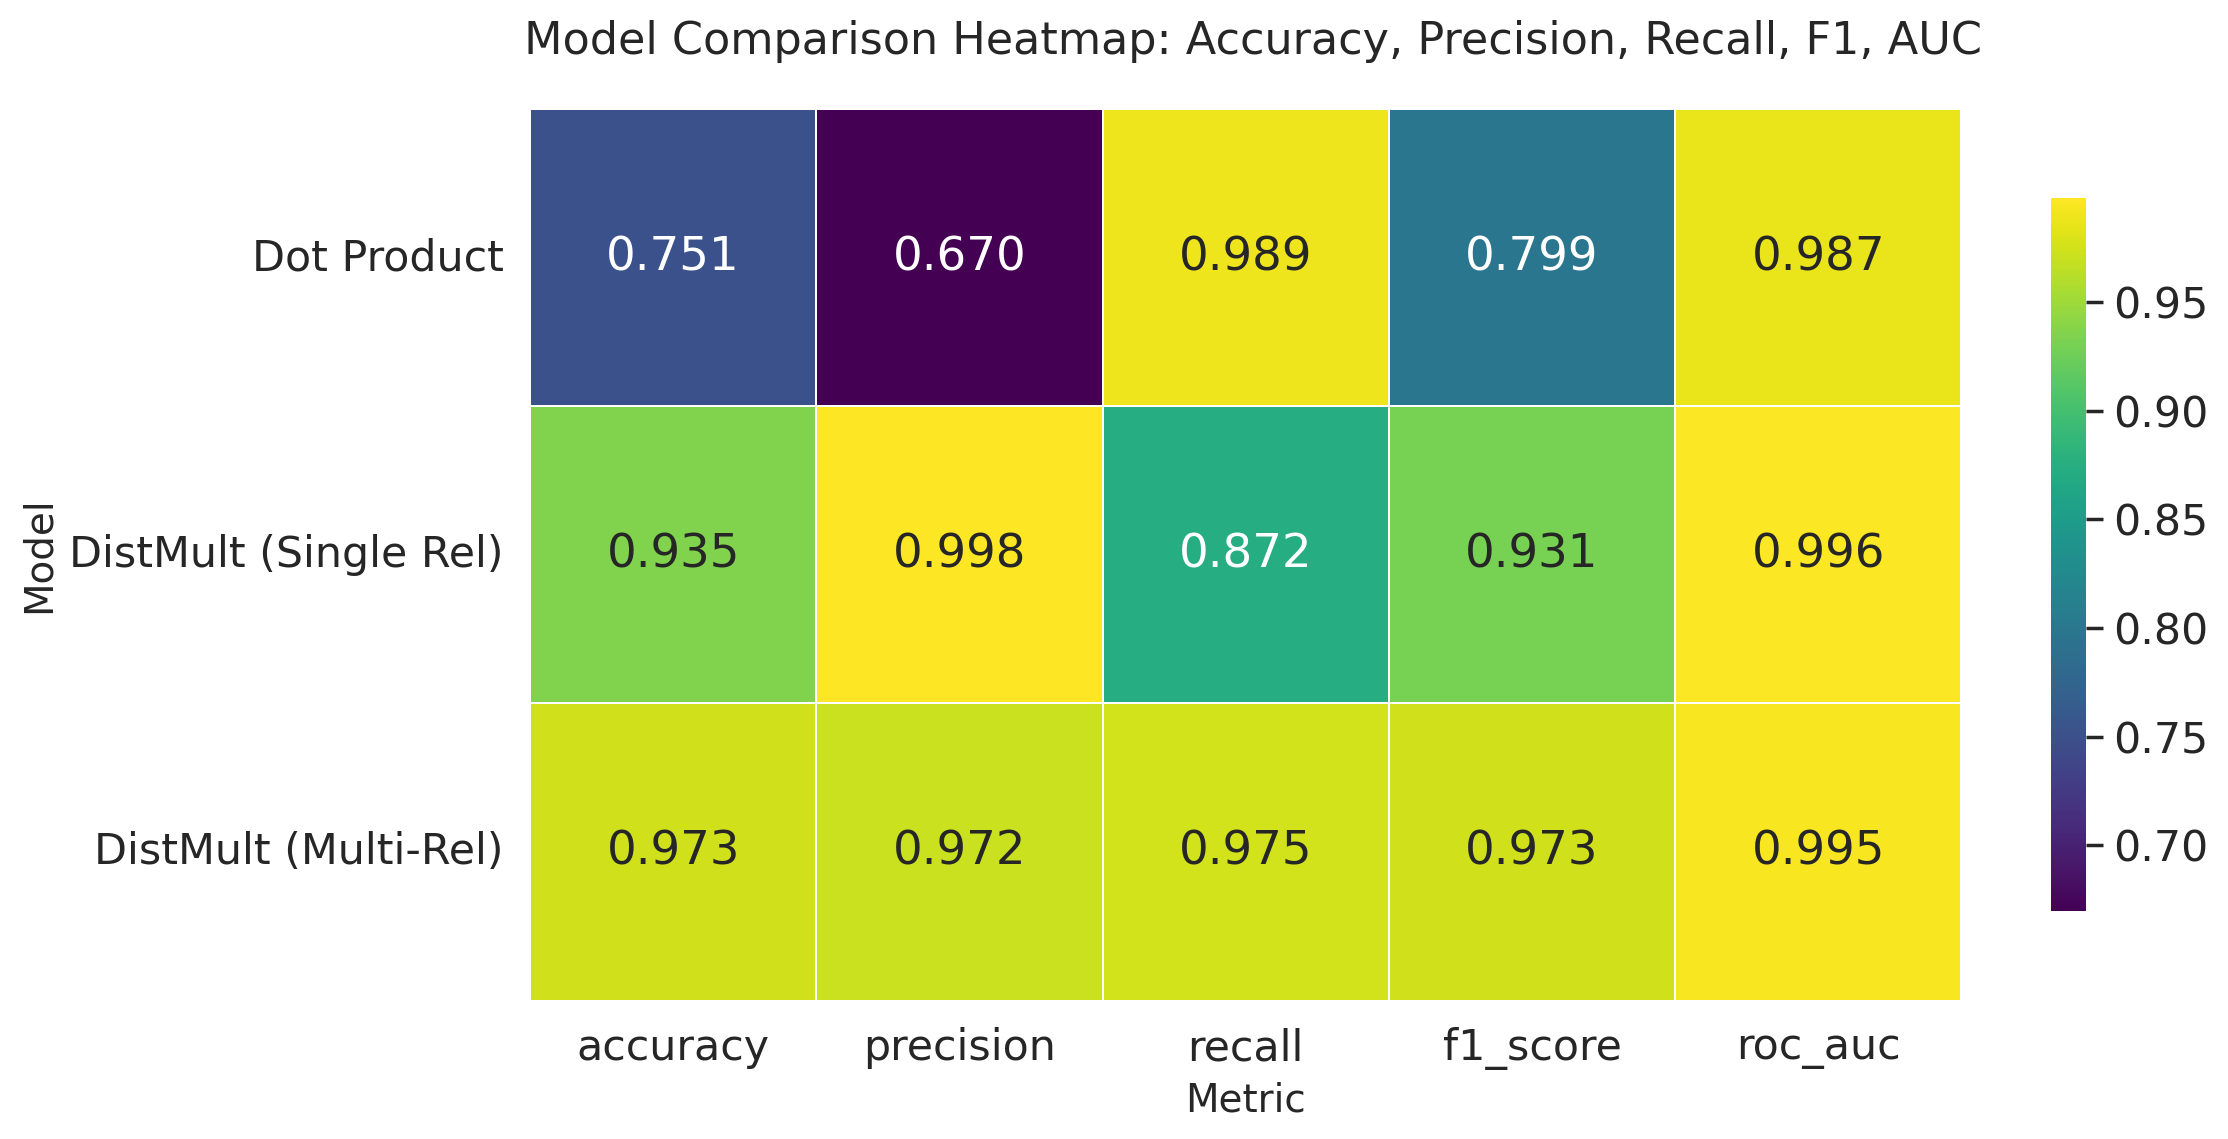

In [11]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# File paths
paths = {
    "Dot Product": "/content/drive/MyDrive/rgcn_dotprod_metrics.json",
    "DistMult (Single Rel)": "/content/drive/MyDrive/rgcn_distmult_metrics.json",
    "DistMult (Multi-Rel)": "/content/drive/MyDrive/rgcn_distmult_multirel_metrics.json"
}

# Unified list of metrics
metrics = ["accuracy", "precision", "recall", "f1_score", "roc_auc"]
target_relation = "('disease', 'disease_phenotype_positive', 'phenotype')"

# Map AUC inconsistencies
alternate_auc_key = {
    "Dot Product": "auc",
    "DistMult (Single Rel)": "roc_auc",
    "DistMult (Multi-Rel)": "roc_auc"
}

# Extract and normalize metrics
scores = {}
for model, path in paths.items():
    with open(path, "r") as f:
        data = json.load(f)

    row = {}
    for metric in metrics:
        key = metric
        if metric == "roc_auc":
            key = alternate_auc_key[model]  # Fix for Dot Product

        if model == "DistMult (Multi-Rel)":
            if target_relation in data and key in data[target_relation]:
                row[metric] = data[target_relation][key][-1]
        else:
            if key in data:
                row[metric] = data[key][-1]
    scores[model] = row

# Create DataFrame
df = pd.DataFrame(scores).T
df = df[metrics]

# Plot the heatmap
plt.figure(figsize=(12, 6), dpi=200)
sns.set(font_scale=1.4)
ax = sns.heatmap(df, annot=True, fmt=".3f", cmap="viridis", linewidths=0.6, cbar_kws={"shrink": 0.8})

plt.title(" Model Comparison Heatmap: Accuracy, Precision, Recall, F1, AUC", fontsize=16, pad=20)
plt.ylabel("Model", fontsize=14)
plt.xlabel("Metric", fontsize=14)
plt.tight_layout()
plt.show()


### Explaining Predictions with GNNExplainer on Biomedical Graphs

This block demonstrates how to **interpret the predictions** of a trained R-GCN model using **GNNExplainer**. In this example, we explore why the model believes a link might (or might not) exist between:

**Disease:** _Permanent Neonatal Diabetes Mellitus_  
**Phenotype:** _Retinopathy_

---

#### Key Steps:

- **Model Setup**: A trained R-GCN with dot product decoding is loaded.
- **Prediction**: The model computes a link score between the selected disease and phenotype.
- **Explanation**: `GNNExplainer` identifies the most influential edges in the graph that contributed to the prediction.
- **Visualization**: A subgraph is generated using PyVis to show the most relevant connections.

---

In [12]:
import torch
import torch.nn.functional as F
import pickle
from torch_geometric.nn import RGCNConv
from torch_geometric.data import HeteroData
from torch_geometric.explain import Explainer, GNNExplainer
from pyvis.network import Network
import networkx as nx
from IPython.display import display, HTML

# Load data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hetero_dict = torch.load("/content/drive/MyDrive/hetero_data_dict.pt", map_location=device)
hetero_data = HeteroData.from_dict(hetero_dict).to(device)

with open("/content/drive/MyDrive/node_maps.pkl", "rb") as f:
    node_maps = pickle.load(f)

edge_types = list(hetero_data.edge_types)
relation_to_id = {rel: i for i, rel in enumerate(edge_types)}

# Define R-GCN encoder
class RGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)

    def forward(self, x, edge_index, edge_type):
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_type)
        return x

# Dot Product predictor
class DotProductPredictor(torch.nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder

    def forward(self, x, edge_index, edge_type, edge_label_index):
        z = self.encoder(x, edge_index, edge_type)
        src = z[edge_label_index[0]]
        dst = z[edge_label_index[1]]
        return (src * dst).sum(dim=-1)

# Load trained encoder
encoder = RGCNEncoder(128, 256, 128, len(edge_types)).to(device)
encoder.load_state_dict(torch.load("/content/drive/MyDrive/rgcn_dotprod_v4.pt", map_location=device))
predictor = DotProductPredictor(encoder).to(device)
predictor.eval()

# Choose nodes to explain
disease = "permanent neonatal diabetes mellitus"
phenotype = "retinopathy"
src_idx = node_maps["disease"].get(disease)
dst_idx = node_maps["phenotype"].get(phenotype)

# Prepare graph inputs
all_x = torch.cat([hetero_data[n].x for n in hetero_data.node_types], dim=0)

edge_index_all = []
edge_type_all = []
for etype, eidx in hetero_data.edge_index_dict.items():
    rel_index = relation_to_id[etype]
    edge_index_all.append(eidx)
    edge_type_all.append(torch.full((eidx.size(1),), rel_index, dtype=torch.long, device=device))

edge_index_cat = torch.cat(edge_index_all, dim=1)
edge_type_cat = torch.cat(edge_type_all)

edge_label_index = torch.tensor([[src_idx], [dst_idx]], device=device)

# Setup GNNExplainer
explainer = Explainer(
    model=predictor,
    algorithm=GNNExplainer(epochs=100),
    explanation_type="model",
    edge_mask_type="object",
    model_config=dict(
        mode="binary_classification",
        task_level="edge",
        return_type="raw",
    ),
)

# Run explanation
explanation = explainer(
    x=all_x,
    edge_index=edge_index_cat,
    edge_type=edge_type_cat,
    edge_label_index=edge_label_index
)

# Visualize explanation
def display_explanation_subgraph(explanation, edge_index, node_maps, top_k=15):
    edge_mask = explanation.edge_mask
    topk = edge_mask.topk(top_k)
    selected_edges = edge_index[:, topk.indices].cpu().numpy()

    reverse_node_map = {}
    for node_type, mapping in node_maps.items():
        for name, idx in mapping.items():
            reverse_node_map[int(idx)] = (name, node_type)

    G = nx.DiGraph()
    for u, v in zip(selected_edges[0], selected_edges[1]):
        u = int(u)
        v = int(v)
        u_name, u_type = reverse_node_map.get(u, (str(u), "unknown"))
        v_name, v_type = reverse_node_map.get(v, (str(v), "unknown"))

        G.add_node(u, label=u_name, title=f"{u_name} ({u_type})", group=u_type)
        G.add_node(v, label=v_name, title=f"{v_name} ({v_type})", group=v_type)
        G.add_edge(u, v)

    net = Network(height="600px", width="100%", notebook=True, directed=True, cdn_resources="in_line")
    net.from_nx(G)
    net.show("/content/drive/MyDrive/gnn_explanation_dotprod.html")


# Show subgraph
display_explanation_subgraph(explanation, edge_index_cat, node_maps)

# Score on full graph
with torch.no_grad():
    full_score = predictor(
        x=all_x,
        edge_index=edge_index_cat,
        edge_type=edge_type_cat,
        edge_label_index=edge_label_index
    )
    full_prob = torch.sigmoid(full_score).item()
    print(f"\n Full graph prediction score for '{disease}' ↔ '{phenotype}': {full_prob:.4f}")

# Score on subgraph only
masked_edge_index = explanation.edge_index[:, explanation.edge_mask.bool()]
masked_edge_type = edge_type_cat[explanation.edge_mask.bool()]

with torch.no_grad():
    subgraph_score = predictor(
        x=all_x,
        edge_index=masked_edge_index,
        edge_type=masked_edge_type,
        edge_label_index=edge_label_index
    )
    subgraph_prob = torch.sigmoid(subgraph_score).item()
    print(f" Confidence score using only GNNExplainer's subgraph: {subgraph_prob:.4f}")

# Display in notebook
with open("/content/drive/MyDrive/gnn_explanation_dotprod.html", "r", encoding="utf-8") as f:
    html_content = f.read()

display(HTML(html_content))


<ipython-input-12-bfd18a9bdb0e>:13: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

<ipython-input-12-bfd18a9bdb0e>:49: FutureWarning:

You are using `torch.load` with `weight

/content/drive/MyDrive/gnn_explanation_dotprod.html

 Full graph prediction score for 'permanent neonatal diabetes mellitus' ↔ 'retinopathy': 0.8299
 Confidence score using only GNNExplainer's subgraph: 1.0000


##DistMult Decoder GNN explainer

In [13]:
import torch
import torch.nn.functional as F
import pickle
from torch_geometric.nn import RGCNConv
from torch_geometric.data import HeteroData
from torch_geometric.explain import Explainer, GNNExplainer
from pyvis.network import Network
import networkx as nx
from IPython.display import display, HTML

# Load device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load graph + metadata ===
hetero_dict = torch.load("/content/drive/MyDrive/hetero_data_dict.pt", map_location=device)
hetero_data = HeteroData.from_dict(hetero_dict).to(device)

with open("/content/drive/MyDrive/node_maps.pkl", "rb") as f:
    node_maps = pickle.load(f)

edge_types = list(hetero_data.edge_types)
relation_to_id = {rel: i for i, rel in enumerate(edge_types)}

# === Define models ===
class RGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)

    def forward(self, x, edge_index, edge_type):
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_type)
        return x

class DistMultPredictor(torch.nn.Module):
    def __init__(self, encoder, embedding_dim, num_relations):
        super().__init__()
        self.encoder = encoder
        self.rel_embeddings = torch.nn.Embedding(num_relations, embedding_dim)

    def forward(self, x, edge_index, edge_type, edge_label_index, edge_type_ids):
        z = self.encoder(x, edge_index, edge_type)
        src = z[edge_label_index[0]]
        dst = z[edge_label_index[1]]
        rel = self.rel_embeddings(edge_type_ids)
        return (src * rel * dst).sum(dim=-1)

# === Load model checkpoint ===
ckpt = torch.load("/content/drive/MyDrive/rgcn_distmult_v4_metrics.pt", map_location=device)
encoder = RGCNEncoder(128, 256, 128, len(edge_types)).to(device)
encoder.load_state_dict(ckpt['encoder_state_dict'])

predictor = DistMultPredictor(encoder, 128, len(edge_types)).to(device)
predictor.rel_embeddings.load_state_dict({'weight': ckpt['decoder_state_dict']['relation_embeddings.weight']})
predictor.eval()

# === Define query ===
disease = "permanent neonatal diabetes mellitus"
phenotype = "retinopathy"
rel = ("disease", "disease_phenotype_positive", "phenotype")
src_idx = node_maps["disease"].get(disease)
dst_idx = node_maps["phenotype"].get(phenotype)
rel_id = torch.tensor([relation_to_id[rel]], device=device)

# === Prepare graph input ===
all_x = torch.cat([hetero_data[n].x for n in hetero_data.node_types], dim=0)

edge_index_all, edge_type_all = [], []
for etype, eidx in hetero_data.edge_index_dict.items():
    rel_index = relation_to_id[etype]
    edge_index_all.append(eidx)
    edge_type_all.append(torch.full((eidx.size(1),), rel_index, dtype=torch.long, device=device))

edge_index_cat = torch.cat(edge_index_all, dim=1)
edge_type_cat = torch.cat(edge_type_all)

edge_label_index = torch.tensor([[src_idx], [dst_idx]], device=device)

# === Run GNNExplainer ===
explainer = Explainer(
    model=predictor,
    algorithm=GNNExplainer(epochs=100),
    explanation_type="model",
    edge_mask_type="object",
    model_config=dict(
        mode="binary_classification",
        task_level="edge",
        return_type="raw",
    ),
)

explanation = explainer(
    x=all_x,
    edge_index=edge_index_cat,
    edge_type=edge_type_cat,
    edge_label_index=edge_label_index,
    edge_type_ids=rel_id
)

# === Visualize explanation ===
def display_explanation_subgraph(explanation, edge_index, node_maps, top_k=15):
    edge_mask = explanation.edge_mask
    topk = edge_mask.topk(top_k)
    selected_edges = edge_index[:, topk.indices].cpu().numpy()

    reverse_node_map = {}
    for node_type, mapping in node_maps.items():
        for name, idx in mapping.items():
            reverse_node_map[int(idx)] = (name, node_type)

    G = nx.DiGraph()
    for u, v in zip(selected_edges[0], selected_edges[1]):
        u = int(u)
        v = int(v)
        u_name, u_type = reverse_node_map.get(u, (str(u), "unknown"))
        v_name, v_type = reverse_node_map.get(v, (str(v), "unknown"))

        G.add_node(u, label=u_name, title=f"{u_name} ({u_type})", group=u_type)
        G.add_node(v, label=v_name, title=f"{v_name} ({v_type})", group=v_type)
        G.add_edge(u, v)

    net = Network(height="600px", width="100%", notebook=True, directed=True, cdn_resources="in_line")
    net.from_nx(G)
    net.show("gnn_explanation_distmult_single.html")

display_explanation_subgraph(explanation, edge_index_cat, node_maps)

# === Score on full graph ===
with torch.no_grad():
    full_score = predictor(
        x=all_x,
        edge_index=edge_index_cat,
        edge_type=edge_type_cat,
        edge_label_index=edge_label_index,
        edge_type_ids=rel_id
    )
    full_prob = torch.sigmoid(full_score).item()
    print(f"\n Full graph prediction score for '{disease}' ↔ '{phenotype}': {full_prob:.4f}")

# === Score on subgraph only ===
masked_edge_index = explanation.edge_index[:, explanation.edge_mask.bool()]
masked_edge_type = edge_type_cat[explanation.edge_mask.bool()]

with torch.no_grad():
    subgraph_score = predictor(
        x=all_x,
        edge_index=masked_edge_index,
        edge_type=masked_edge_type,
        edge_label_index=edge_label_index,
        edge_type_ids=rel_id
    )
    subgraph_prob = torch.sigmoid(subgraph_score).item()
    print(f" Confidence score using only GNNExplainer's subgraph: {subgraph_prob:.4f}")

# === Inline display ===
with open("gnn_explanation_distmult_single.html", "r", encoding="utf-8") as f:
    html_content = f.read()

display(HTML(html_content))


<ipython-input-13-0629e20bbd25>:15: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

<ipython-input-13-0629e20bbd25>:51: FutureWarning:

You are using `torch.load` with `weight

gnn_explanation_distmult_single.html

 Full graph prediction score for 'permanent neonatal diabetes mellitus' ↔ 'retinopathy': 0.0477
 Confidence score using only GNNExplainer's subgraph: 1.0000


##DistMult Decoder + Multi relations GNN explainer

In [14]:
import torch
import torch.nn.functional as F
import pickle
from torch_geometric.nn import RGCNConv
from torch_geometric.data import HeteroData
from torch_geometric.explain import Explainer, GNNExplainer
from pyvis.network import Network
import networkx as nx
from IPython.display import display, HTML

# Load device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load hetero data
hetero_dict = torch.load("/content/drive/MyDrive/hetero_data_dict.pt", map_location=device)
hetero_data = HeteroData.from_dict(hetero_dict).to(device)

with open("/content/drive/MyDrive/node_maps.pkl", "rb") as f:
    node_maps = pickle.load(f)

edge_types = list(hetero_data.edge_types)
relation_to_id = {rel: i for i, rel in enumerate(edge_types)}

# Encoder model
class RGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)

    def forward(self, x, edge_index, edge_type):
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_type)
        return x

# DistMult predictor
class DistMultPredictor(torch.nn.Module):
    def __init__(self, encoder, embedding_dim, num_relations):
        super().__init__()
        self.encoder = encoder
        self.rel_embeddings = torch.nn.Embedding(num_relations, embedding_dim)

    def forward(self, x, edge_index, edge_type, edge_label_index, edge_type_ids):
        z = self.encoder(x, edge_index, edge_type)
        src = z[edge_label_index[0]]
        dst = z[edge_label_index[1]]
        rel = self.rel_embeddings(edge_type_ids)
        return (src * rel * dst).sum(dim=-1)

# Load trained model
embedding_dim = 128
encoder = RGCNEncoder(128, 256, embedding_dim, len(edge_types)).to(device)
decoder_ckpt = torch.load("/content/drive/MyDrive/rgcn_distmult_multirel_metrics.pt", map_location=device)

encoder.load_state_dict(decoder_ckpt['encoder_state_dict'])

predictor = DistMultPredictor(encoder, embedding_dim, len(edge_types)).to(device)
predictor.rel_embeddings.load_state_dict({'weight': decoder_ckpt['decoder_state_dict']['relation_embeddings.weight']})
predictor.eval()

# Choose link to explain
disease = "permanent neonatal diabetes mellitus"
phenotype = "retinopathy"
rel = ("disease", "disease_phenotype_positive", "phenotype")
src_idx = node_maps["disease"].get(disease)
dst_idx = node_maps["phenotype"].get(phenotype)
rel_id = torch.tensor([relation_to_id[rel]], device=device)

# Prepare input
all_x = torch.cat([hetero_data[n].x for n in hetero_data.node_types], dim=0)

edge_index_all = []
edge_type_all = []
for etype, eidx in hetero_data.edge_index_dict.items():
    rel_index = relation_to_id[etype]
    edge_index_all.append(eidx)
    edge_type_all.append(torch.full((eidx.size(1),), rel_index, dtype=torch.long, device=device))

edge_index_cat = torch.cat(edge_index_all, dim=1)
edge_type_cat = torch.cat(edge_type_all)

# Setup GNNExplainer
explainer = Explainer(
    model=predictor,
    algorithm=GNNExplainer(epochs=100),
    explanation_type="model",
    edge_mask_type="object",
    model_config=dict(
        mode="binary_classification",
        task_level="edge",
        return_type="raw",
    ),
)

edge_label_index = torch.tensor([[src_idx], [dst_idx]], device=device)

# Run explanation
explanation = explainer(
    x=all_x,
    edge_index=edge_index_cat,
    edge_type=edge_type_cat,
    edge_label_index=edge_label_index,
    edge_type_ids=rel_id
)

# Visualize explanation subgraph
def display_explanation_subgraph(explanation, edge_index, node_maps, top_k=15):
    edge_mask = explanation.edge_mask
    topk = edge_mask.topk(top_k)
    selected_edges = edge_index[:, topk.indices].cpu().numpy()

    reverse_node_map = {}
    for node_type, mapping in node_maps.items():
        for name, idx in mapping.items():
            reverse_node_map[idx] = (name, node_type)

    G = nx.DiGraph()
    for u, v in zip(selected_edges[0], selected_edges[1]):
        u_name, u_type = reverse_node_map.get(u, (str(u), "unknown"))
        v_name, v_type = reverse_node_map.get(v, (str(v), "unknown"))
        u_id = int(u)
        v_id = int(v)
        G.add_node(u_id, label=u_name, title=f"{u_name} ({u_type})", group=u_type)
        G.add_node(v_id, label=v_name, title=f"{v_name} ({v_type})", group=v_type)
        G.add_edge(u_id, v_id)

    net = Network(height="600px", width="100%", notebook=True, directed=True, cdn_resources="in_line")
    net.from_nx(G)
    net.show("/content/drive/MyDrive/gnn_explanation_multirel_v3.html")

# Call visualization
display_explanation_subgraph(explanation, edge_index_cat, node_maps)

# Confidence score (full graph)
with torch.no_grad():
    full_score = predictor(
        x=all_x,
        edge_index=edge_index_cat,
        edge_type=edge_type_cat,
        edge_label_index=edge_label_index,
        edge_type_ids=rel_id
    )
    full_prob = torch.sigmoid(full_score).item()
    print(f"\n Full graph prediction score for '{disease}' ↔ '{phenotype}': {full_prob:.4f}")

# Confidence score (explanation subgraph)
masked_edge_index = explanation.edge_index[:, explanation.edge_mask.bool()]
masked_edge_type = edge_type_cat[explanation.edge_mask.bool()]

with torch.no_grad():
    subgraph_score = predictor(
        x=all_x,
        edge_index=masked_edge_index,
        edge_type=masked_edge_type,
        edge_label_index=edge_label_index,
        edge_type_ids=rel_id
    )
    subgraph_prob = torch.sigmoid(subgraph_score).item()
    print(f" Confidence score using only GNNExplainer's subgraph: {subgraph_prob:.4f}")

# Show in notebook
with open("/content/drive/MyDrive/gnn_explanation_multirel_v3.html", "r", encoding="utf-8") as f:
    html_content = f.read()

display(HTML(html_content))


<ipython-input-14-47c3e688ef15>:15: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

<ipython-input-14-47c3e688ef15>:54: FutureWarning:

You are using `torch.load` with `weight

/content/drive/MyDrive/gnn_explanation_multirel_v3.html

 Full graph prediction score for 'permanent neonatal diabetes mellitus' ↔ 'retinopathy': 0.9998
 Confidence score using only GNNExplainer's subgraph: 1.0000
